Isaac Getto and Zoher Ghadyali

Data Science Spring 2016

CTW Project

The initial goal for this project was to look at Congress and try and quantify why the Congressional approval rating has been below 10% for several consecutive years using a data-driven story-telling approach. Unfortunately, we had to spend a large chunk of this project scraping our data from [senate.gov](http://www.senate.gov/index.htm) and [congress.gov](https://www.congress.gov/) and, as a result, have only been able to look at the U.S. Senate during the 1st session of the 114th Congress, from January 8th, 2015 to December 18th, 2015. Below is our work.

# The U.S. Senate #

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import datetime
import pandas as pd
import operator

import sys
sys.path.append('../data')

import congress_db
from setup_db import Candidate, Contribution, Committee
from sqlalchemy import func

session = congress_db.create_session()

df = pd.read_csv('../data/rollCallVotes_cleaned.csv')
only_bills = df[df['voteResult'].isin(['Amendment Rejected', 'Amendment Agreed to', 'Bill Passed', 'Bill Defeated', 
                          'Concurrent Resolution Agreed to', 'Concurrent Resolution Rejected', 
                          'Joint Resolution Passed', 'Joint Resolution Defeated'])].reset_index()

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The above code imports our packages and the data we have found online or scraped. We have pushed all of our data sources to Github and invite you to further explore with them and at the end of this notebook, provided several examples of further work to do with this data.

We created a sql database to store our data from the FEC on the funding raised by individual candidates running for the Senate, who in turn make up the senators whose voting record are shown in [rollCallVotes_cleaned.csv](https://github.com/idgetto/DataScience16CTW/blob/master/data/rollCallVotes_cleaned.csv). 

This csv file showing the voting record contains all roll call votes for this session of the Senate, which includes several motions on each bill. For example, a roll call vote may be on a motion to end [cloture](https://en.wikipedia.org/wiki/Cloture), a process used in the Senate to end discussion on a bill and force a vote. Since we do not want the votes on these motions to impact our visualizations of how senators are voting on actual legislation, we create a dataframe that contains only the roll call votes that directly result in legislation either passing the Senate or failing.

## Party Contributions over an Election Cycle ##

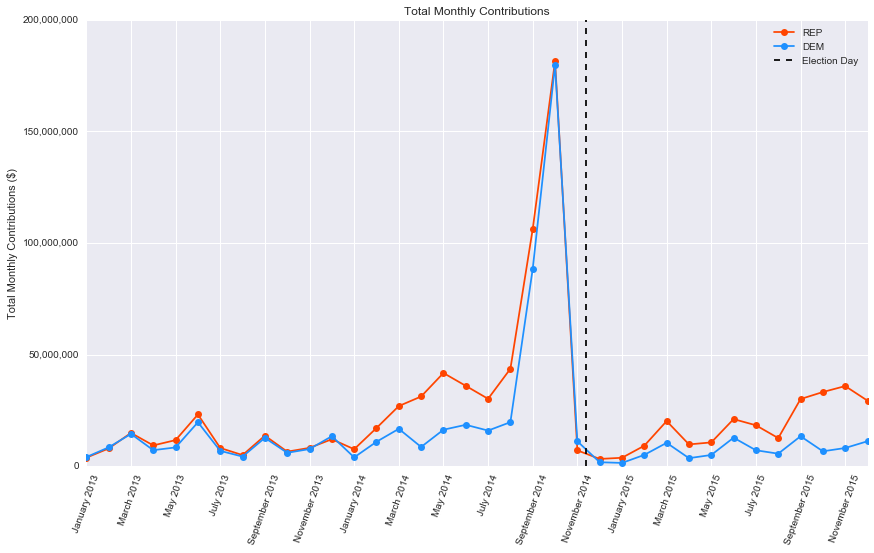

In [3]:
import contributions

plt.figure(figsize=(14, 8))
contributions.plot_monthly_dollars_by_party('REP', color='orangered')
contributions.plot_monthly_dollars_by_party('DEM', color='dodgerblue', election_date=datetime.date(2014, 11, 4))
plt.show()

Here, we can see how the total contributions to each party change from month to month. We can clearly see a spike in the total contribution dollar amount as we approach the election day in November. Both parties have similar trends in the amount of contributions received over time. It also appears that Republicans receive slightly more money each month.

## Party Sponsorship Breakdown ##


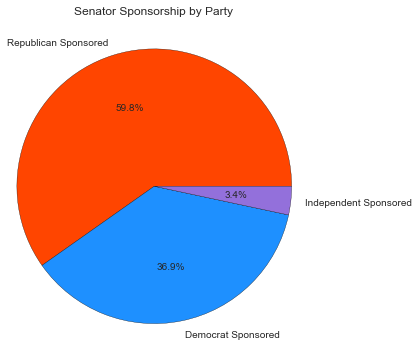

In [4]:
rep_count = 0
dem_count = 0
ind_count = 0
for sponsor in only_bills.sponsor:
    if sponsor.split()[1][1] == 'R':
        rep_count += 1
    elif sponsor.split()[1][1] == 'D':
        dem_count += 1
    elif sponsor.split()[1][1] == 'I':
        ind_count += 1
res = [float(rep_count)/len(only_bills), float(dem_count)/len(only_bills), float(ind_count)/len(only_bills)]
fig = plt.figure(figsize=(5,5))
plt.pie([res[0]*100, res[1]*100, res[2]*100],
        labels=['Republican Sponsored', 'Democrat Sponsored', 'Independent Sponsored'],
        colors=['orangered', 'dodgerblue', 'mediumpurple'],autopct='%1.1f%%')
plt.axis('equal')
plt.title('Senator Sponsorship by Party',  y=1.1)
plt.show()

We loop through all of the bills we have found and look at the party of the senator who sponsored that legislation. A senator sponsors a piece of legislation when they are the first person to bring that legislation to the floor of the Senate. The Senate of the 114th Congress is controlled by the Republican party so thus, we see that near 60% of bills are sponsored by Republicans, with only 37% of bills sponsored by Democrats and 3.4% sponsored by independents, which is a significant amount since there are only 2 independent senators.

One reason for the lack of Democrat sponsorship could be the fact that in a Republican-controlled Senate, Democrats have very little faith that legislation they take the effort to sponsor will pass and this would be a testament to the strength of partisanship in the Senate. Independents, on the other hand, sponsor more legislation because their party does not serve as a hindrance to the bills they sponsor being passed by the majority of the Senate.

## Party sponsorship status ##

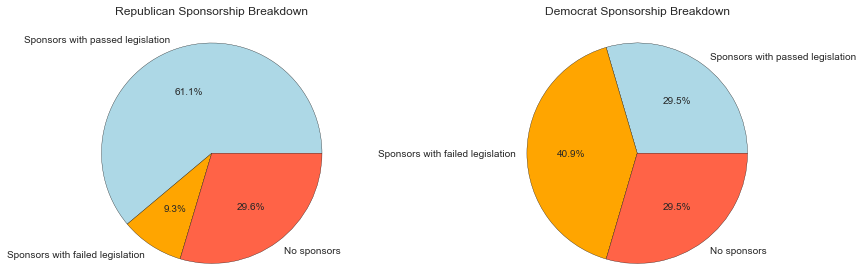

In [5]:
senators = df.ix[:,0:100]
dems = [col for col in senators.columns if col.split()[1][1] == 'D']
reps = [col for col in senators.columns if col.split()[1][1] == 'R']
independents = [col for col in senators.columns if col.split()[1][1] == 'I']    

def sponsor_effectiveness(senator):
    sponsored_bills = only_bills[only_bills.sponsor == senator].reset_index()
    count = 0
    for i in range(0, len(sponsored_bills.voteResult)):
        if any(word in sponsored_bills.voteResult[i] for word in ['Agreed to', 'Passed']):
            count += 1
    if len(sponsored_bills.voteResult):
        return float(count) / len(sponsored_bills.voteResult)
    else:
        return None

def sponsor_breakdown(sen_list, title, pos):
    bills_passed = 0
    bills_failed = 0
    no_sponsors = 0
    for senator in sen_list:
        percentage_passed = sponsor_effectiveness(senator)
        if percentage_passed:
            bills_passed += 1
        elif percentage_passed == 0:
            bills_failed += 1
        else:
            no_sponsors += 1
    res = [float(bills_passed)/len(sen_list), float(bills_failed)/len(sen_list), float(no_sponsors)/len(sen_list)]
    plt.subplot(1, 2, pos)
    plt.pie([res[0]*100, res[1]*100, res[2]*100],
            labels=['Sponsors with passed legislation', 'Sponsors with failed legislation', 'No sponsors'],
            colors=['lightblue', 'orange', 'tomato'],autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(title,  y=1.1)
    return


plt.figure(figsize=(14,4))
sponsor_breakdown(reps, 'Republican Sponsorship Breakdown', 1)
sponsor_breakdown(dems, 'Democrat Sponsorship Breakdown', 2)
plt.show()

So the previous pie chart told us what percentage of bills were sponsored by each party but we don't know anything about the status of those bills. So now we go through each party and count the percentage of senators in that party who sponsored and passed at least one piece of legislation, the percentage of senators whose sponsored legislation failed to pass the Sente, and the percentage of senators who did not sponsor any legislation. We do not include independents since there are only two senators who are independent and we want to focus on the larger role of partisanship in the Senate.

We can clearly see that the percentage of senators who do not sponsor legislation is similar between the Republicans and Democrats, with only a difference of 0.1%. We see the role of partisanship in the fact that 61% of Republican senators have sponsored at least one piece of legislation that has passed the Senate while less than half of that, 29.5% of Democrats have accomplished that. Instead, we see that 41% of Democrats have sponsored legislation that did not pass the Senate and this speaks to the lower percentage of bills sponsored by Democrats that we saw in the previous plot.

## Top Contributors to each Party ##

In [42]:
import datetime

def top_contributors_by_party(party):
    return session.query(func.sum(Contribution.tx_amount).label('total_cont'), Committee.name).\
                filter(Contribution.tx_date > datetime.date(2012, 11, 4)).\
                join(Committee).\
                filter(Committee.committee_type.in_('CDEINOPQUVWXYZ')).\
                filter(Committee.designation != 'P').\
                join(Candidate).\
                filter(Candidate.party == party).\
                filter(Candidate.office == 'S').\
                group_by(Contribution.committee_id).\
                order_by('total_cont desc').\
                all()
                
def plot_top_contributors_by_party(party):
    dollars, committees = zip(*top_contributors_by_party(party))

    plt.figure(figsize=(12, 6))
    sns.barplot(dollars[:10], committees[:10], ci=None)
    
    # format for dollars
    a = plt.gca()
    a.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    plt.xlabel('Total Contributions ($)')
    plt.title('Top Committees contributing to ' + party + ' party')
    plt.show()

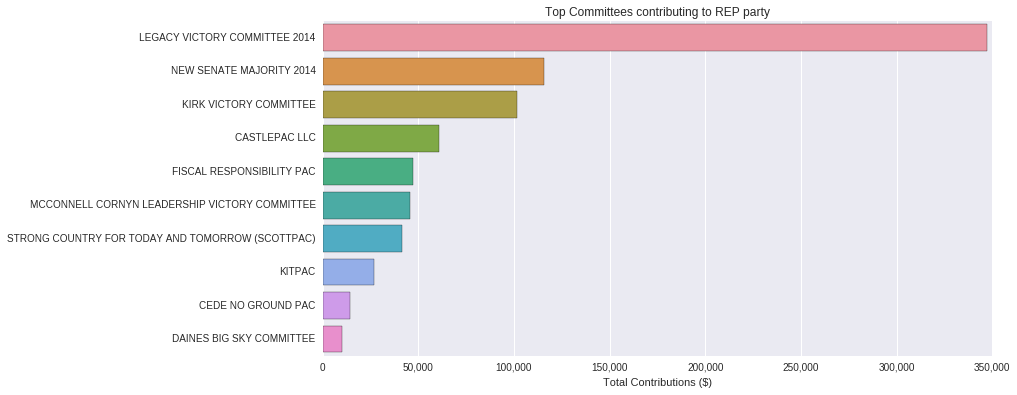

In [43]:
plot_top_contributors_by_party('REP')

The above plot shows the top contributors to members of the republican party. This figure excludes most committees that are dedicated to fundraising for a particular candidate. Each of these organizations contribute mostly to conservative candidates that uphold a set of shared principles.

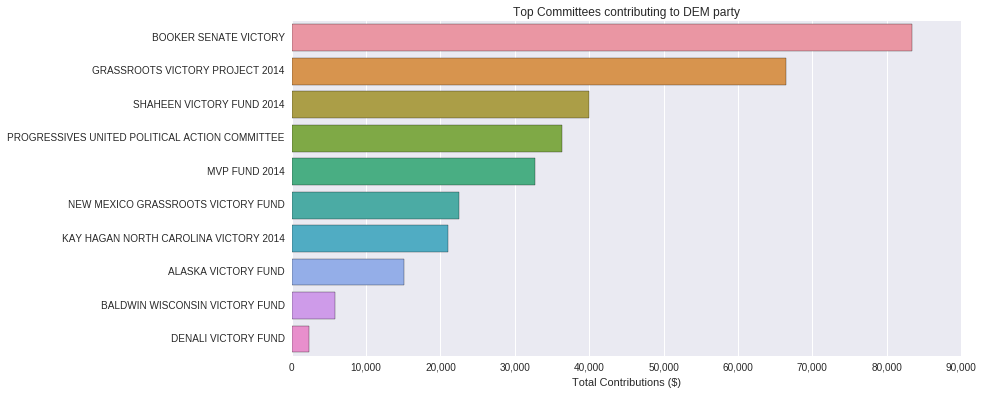

In [44]:
plot_top_contributors_by_party('DEM')

Here are the top contributors to the Democratic party. These committees are associated with progressive opinions and support liberal candidates.

## Top 5 Senator Sponsors by Party ##

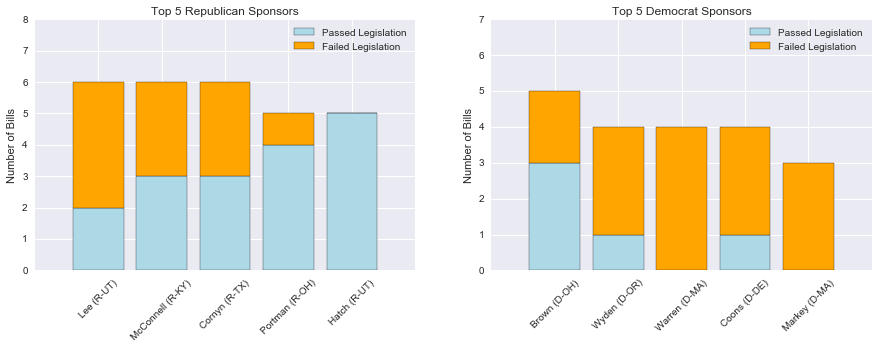

In [9]:
sponsored_no = {}
for sponsor in only_bills.sponsor:
    if sponsor in sponsored_no:
        sponsored_no[sponsor] += 1
    else:
        sponsored_no[sponsor] = 1

sorted_sponsored_no = sorted(sponsored_no.items(), key=operator.itemgetter(1))[::-1]
rep_sponsors = [sponsor for sponsor in sorted_sponsored_no if sponsor[0].split()[1][1] == 'R']
dem_sponsors = [sponsor for sponsor in sorted_sponsored_no if sponsor[0].split()[1][1] == 'D']

def top_sponsor_effectiveness(sponsor_list, title, pos):
    sen_list = [sponsor[0] for sponsor in sponsor_list[0:5]]
    tot_bills = [sponsor[1] for sponsor in sponsor_list[0:5]]
    successes = []
    fails = []
    for sponsor in sen_list:
        success = 0
        fail = 0
        for result in only_bills[only_bills.sponsor == sponsor].voteResult:
            if any(word in result for word in ['Agreed to', 'Passed']):
                success += 1
            elif any(word in result for word in ['Rejected', 'Failed']):
                fail += 1
        if success + fail != len(only_bills[only_bills.sponsor == sponsor]):
            print "Aw man something is blazed"
        else:
            successes.append(success)
            fails.append(fail)
#     plt.figure(figsize=(8,5))
    plt.subplot(1, 2, pos)
    p1 = plt.bar(range(len(successes)), successes, align='center', color='lightblue')
    p2 = plt.bar(range(len(fails)), fails, align='center', color='orange', bottom=successes)
    plt.axis([-1, len(sen_list), 0, max(tot_bills)+2])
    plt.xticks(range(len(sen_list)), sen_list, rotation=45)
    plt.title(title)
    plt.ylabel('Number of Bills')
    plt.legend((p1[0], p2[0]), ('Passed Legislation', 'Failed Legislation'))
    return 

plt.figure(figsize=(15,4.5))
top_sponsor_effectiveness(rep_sponsors, 'Top 5 Republican Sponsors', 1)
top_sponsor_effectiveness(dem_sponsors, 'Top 5 Democrat Sponsors', 2)
plt.show()

Up to now, we've been looking at sponsorship in the Senate on the party level. We look at sponsorship specifically because other metrics we used to measure how effective senators are, like the number of votes a senator has missed or how often a senator's individual vote aligned with the result of the vote by the Senate, did not vary significantly by party. The plot above finds the 5 senators for each party that have sponsored the greatest number of bills and the legend shows the status of this legislation.

First, we see that among the top 5 Republicans, in a Republican-controlled Senate, the average number of bills sponsored is 5.6 while among the top 5 Democrats, the average is only 4. We also see that the top 5 Republican sponsors have 11 bills that did not pass the Senate while the Democrats, who sponsor less bills in the first place, have 15 bills that did not pass the Senate. Conversely, the top 5 Republican sponsors are more successful than the Democrat sponsors. Again, this shows partisanship in the Senate and how only the party in control of the Senate gets legislation passed.

## How each Party votes on a Topic ##

Below we have a widget where you can search through the 662 subjects that the Senate during the first session of the 114th Congress passed legislation related to. Begin typing the topic you are interested in looking at and the dropdown will automatically filter as a result.

In [10]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

topics = list(df.columns[105:].values)

def topic_search1(query):
    found_topics = []
    for topic in topics:
        if query.lower() in topic.lower():
            found_topics.append(topic)

    topics_drop_widget1.options = found_topics

def topic_search_for_widget1(widget):
    try:
        query = widget['new']['value']
        topic_search1(query)
    except:
        pass
    
topic_search_widget1 = widgets.Text(
    description='Search:',
    value='Immigration'
)

topic_search_widget1.observe(topic_search_for_widget1)

topics_drop_widget1 = widgets.Dropdown(
    options=topics,
    description=' ',
)

topic_search1(topic_search_widget1.value)

display(topic_search_widget1)
display(topics_drop_widget1)


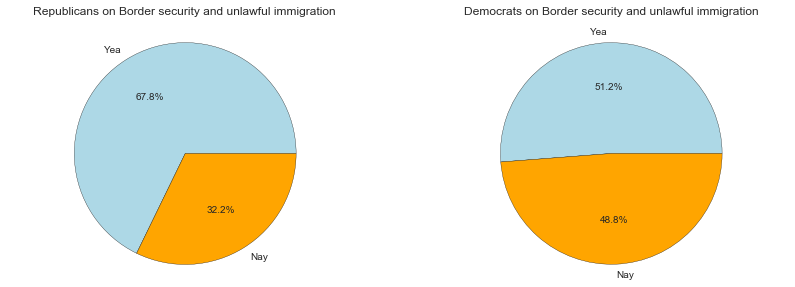

In [11]:
def votes_on_subject(senator, subject):
    subject_df = df[df[subject] == 1]
    senator_subject = subject_df[senator]
    yeas = len(senator_subject[senator_subject == 'Yea'])
    nays = len(senator_subject[senator_subject == 'Nay'])
    if (yeas + nays):
        percent_voted_yea = float(yeas) / (yeas + nays)
        return percent_voted_yea
    else:
        return None

def party_votes_on_subject(sen_list, subject, party, pos):
    tot = 0
    for senator in sen_list:
        if votes_on_subject(senator, subject):
            tot += votes_on_subject(senator, subject)
    avg_voted_yea = tot / len(sen_list)
    labels = 'Yea', 'Nay'
    colors = ['lightblue', 'orange']
    plt.subplot(1, 2, pos)
    plt.pie([avg_voted_yea*100, 100 - avg_voted_yea*100],
            labels=labels, colors=colors, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(party + " on " + subject, y=1.1)
    return

plt.figure(figsize=(14,4))
party_votes_on_subject(reps, topics_drop_widget1.value, 'Republicans', 1)  
party_votes_on_subject(dems, topics_drop_widget1.value, 'Democrats', 2)  

Using your selected topic, we go through the senators in each party and count the amount of times they vote 'Yea' on legislation concerning this topic and the amount of times they vote 'Nay'. We do not count times when a senator is 'Not Voting' on a given subject. We calculate the ratio of the amount of times each senator votes yea to the total amount of times they voted on this topic and then average this along the party.

We were hoping to see the role of partisanship as we have in our previous plots but unfortunately, we do not know more about each bill other than the topics that it concerns. We know that, given the example of gun control, we expect Democrats to vote 'Yea' on stricter legislation while Republicans will vote 'Nay' but we do not know in our data whether the legislation is pro or against gun control, only that it concerns gun control. We are able to see which topics members of each party align on but it is more difficult to see partisanship.

# Investigate your Senators #

In this section, we move past our party-level overview of the Senate to show you several similar plots to the ones you have already seen about your individual senators. Use the widget below to find the senator you want to know more about.

In [12]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

senator_names = list(df.columns[:100].values)

senator_search_widget = widgets.Text(
    description='Search:',
    value='Warren'
)

senator_widget = widgets.Dropdown(
    options=senator_names,
    description=' ',
)

def search_senator_for_widget(widget):
    try:
        query = widget['new']['value']
        search_senator(query)
    except:
        pass

def search_senator(query):
    found_senators = []
    for senator in senator_names:
        if query.lower() in senator.lower():
            found_senators.append(senator)
    senator_widget.options = found_senators

senator_search_widget.observe(search_senator_for_widget)

search_senator(senator_search_widget.value)

display(senator_search_widget)
display(senator_widget)

In [13]:
import re
def get_senator_id(Senator):
    parts = re.split('[ ()-]+', Senator)
    last_name = parts[0]
    party_letter = parts[1]
    state = parts[2]
    
    id = session.query(Candidate.id).\
            filter(Candidate.office_st == state).\
            filter(Candidate.name.like('%' + last_name + '%')).\
            filter(Candidate.party.like(party_letter + '%')).\
            filter(Candidate.office=='S').\
            order_by('Candidate.id desc').\
            first()[0]
    return id

senator_name = senator_widget.value
senator_id = get_senator_id(senator_name)

//anaconda/lib/python2.7/site-packages/sqlalchemy/sql/compiler.py:572: SAWarning: Can't resolve label reference 'Candidate.id desc'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


## Senator Profile ##

In [46]:
senator_info = session.query(Candidate.name, Candidate.office_st, Candidate.party).\
                        filter(Candidate.id == senator_id).\
                        first()
        
full_name, state, party = senator_info

html_str = '<h1>%s</h1><h2>%s - %s</h2>' % (full_name, party, state)
html = widgets.HTML(
    value=html_str
)
display(html)

Now that you have picked a senator to investigate, you should be able to see their full name, party, and state of representation. Next, you will be able to see which committees have contributed most to your senator and how they vote on issues of your choice.

## Top Contributors ##

In [47]:
def committee_total_contributions(senator_id):
    return session.query(func.sum(Contribution.tx_amount).label('total_cont'), Committee.name).\
                filter(Contribution.candidate_id == senator_id).\
                join(Committee).\
                group_by(Contribution.committee_id).\
                order_by('total_cont desc').\
                all()
                
def plot_interest_groups(cand_id, name=None):
    contr = committee_total_contributions(cand_id)
    amounts, committees = zip(*contr)
    
    plt.figure(figsize=(10, 7))
    sns.barplot(amounts[:5], committees[:5], ci=None)
    plt.xlabel('Contribution ($)')
    
    # format for dollars
    a = plt.gca()
    a.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    if name:
        plt.title('Top contributors to ' + name)

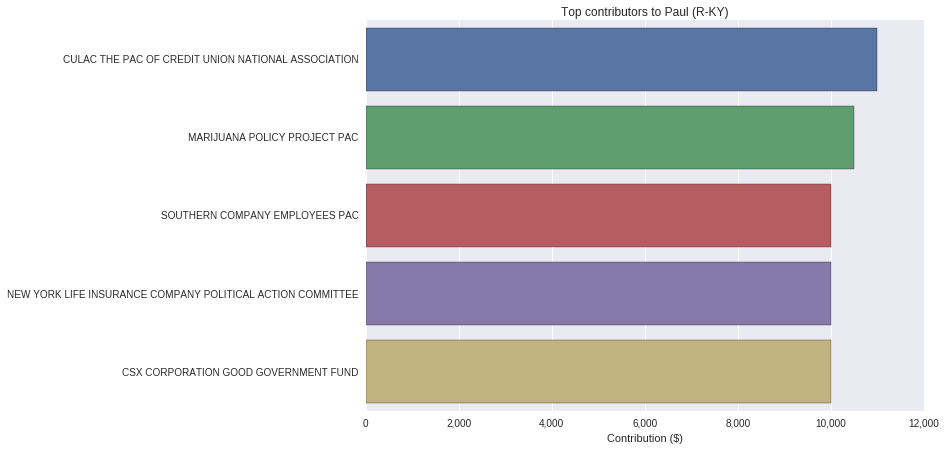

In [48]:
plot_interest_groups(senator_id, senator_name)

The above figure shows which committees donate the most to your candidate. Hopefully, you can look at these groups and find trends about what issues your candidate might feel influenced to support. It might take some research to discover what issues are relevant to each committee.

## Select a Voting Topic ##

Choose a topic below to see how your senator votes on it.

In [49]:
topics = list(df.columns[105:].values)

def topic_search(query):
    found_topics = []
    for topic in topics:
        if query.lower() in topic.lower():
            found_topics.append(topic)

    topics_drop_widget.options = found_topics

def topic_search_for_widget(widget):
    try:
        query = widget['new']['value']
        topic_search(query)
    except:
        pass
    
topic_search_widget = widgets.Text(
    description='Search:',
    value='Immigration'
)

topic_search_widget.observe(topic_search_for_widget)

topics_drop_widget = widgets.Dropdown(
    options=topics,
    description=' ',
)

topic_search(topic_search_widget.value)

display(topic_search_widget)
display(topics_drop_widget)

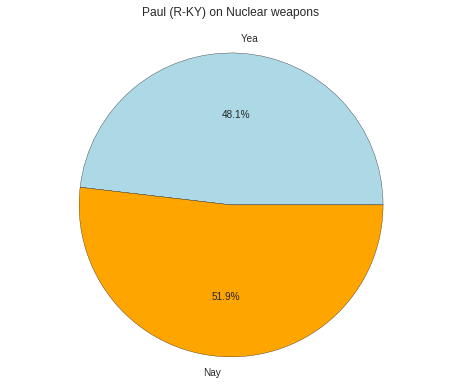

In [50]:
topic = topics_drop_widget.value

percent_voted_yea = votes_on_subject(senator_name, topic)
if percent_voted_yea:
    labels = 'Yea', 'Nay'
    colors = ['lightblue', 'orange']
    plt.pie([percent_voted_yea*100, 100 - percent_voted_yea*100],
                labels=labels, colors=colors, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(senator_name + " on " + topic, y=1.1)
    plt.show()
else:
    print senator_name + " was not present for votes on " + topic

Above, you see how often your selected senator voted 'Yea' or 'Nay' on legislation concerning your selected topic.

## Sponsorship record (pass/fail) ##

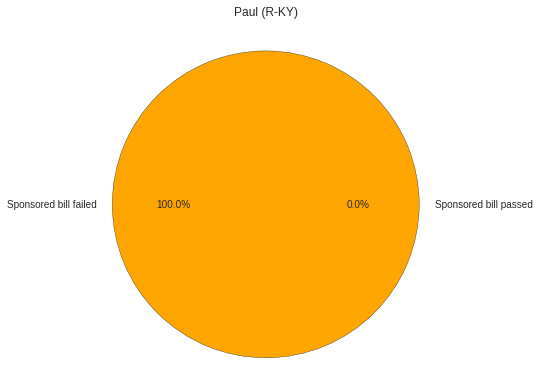

In [51]:
percent_passed = sponsor_effectiveness(senator_name)
if percent_passed != None:        
    labels = 'Sponsored bill passed', 'Sponsored bill failed'
    colors = ['lightblue', 'orange']
    plt.pie([percent_passed*100, 100 - percent_passed*100],
            labels=labels, colors=colors, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(senator_name,  y=1.1)
    plt.show()
else:
    print senator_name, "sponsored no bills during this session of Congress"

Above you see what percentage of legislation that your selected senator sponsored passed the Senate and what percentage did not.

## Voting record compared to their Party ##

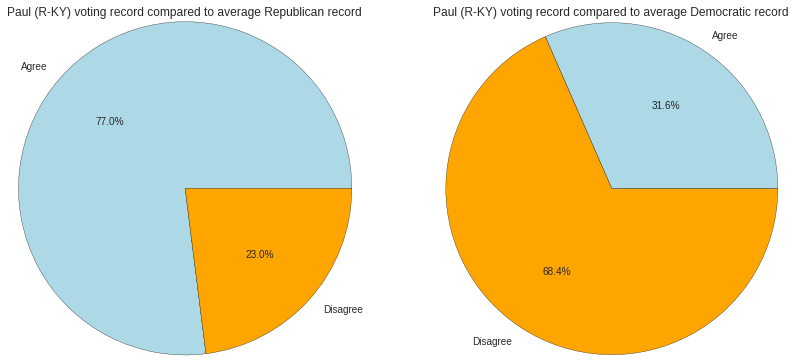

In [52]:
senators = df.ix[:,0:100]
dems = [col for col in senators.columns if col.split()[1][1] == 'D']
reps = [col for col in senators.columns if col.split()[1][1] == 'R']
other = [col for col in senators.columns if col.split()[1][1] not in 'DR']

all_senator_votes = senators.apply(lambda vote: vote == 'Yea')

def get_average_vote(senators):
    votes = all_senator_votes[senators]
    avg_vote = votes.mode(axis=1)[0]
    return avg_vote

df['DEM'] = get_average_vote(dems)
df['REP'] = get_average_vote(reps)

senator_votes = all_senator_votes[senator_name]
dem_inline_votes = df['DEM'] == senator_votes
rep_inline_votes = df['REP'] == senator_votes

dem_inline_percent = sum(dem_inline_votes / float(len(all_senator_votes)))
rep_inline_percent = sum(rep_inline_votes / float(len(all_senator_votes)))


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
colors = ['lightblue', 'orange']

plt.pie([rep_inline_percent, 1-rep_inline_percent],
            labels=['Agree', 'Disagree'], colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title(senator_name + ' voting record compared to average Republican record')

plt.subplot(1, 2, 2)
plt.pie([dem_inline_percent, 1-dem_inline_percent],
            labels=['Agree', 'Disagree'], colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title(senator_name + ' voting record compared to average Democratic record')

plt.show()

Here we can compare your senator's voting record to that of the average Republican and average Democrat. What we have done here is find which bills most members of each party support. Then, we see if your senator has voted the same way as the majority of each of the parties. For most candidates, they should have a voting record mostly inline with their party. This figure can hopefully show how willing your candidate is to compromise or differ from their party's stance.

# Further Work #

Thank you for making it all the way to the end of this notebook. We hope that you found something interesting about the Senate during this first session of the 114th Congress.

We invite you to use our data for further exploration. Below are some ideas we would have loved to pursue:
- Instead of looking at just bills, we could look at the committees a senator is on and gauge each senator's influence beyond sponsorship based on the committee
- Scrape data for multiple sessions of Congress and show how party dominance has changed, how voting on a specific topic has changed, and how senators move through committees
- Create a really cool visualization using motions and bills to show the passage of a bill, congress.gov does this in a way for each bill but tracking trends for all bills would be really cool
- Research the top contributors to each party or even the top contributors to each individual senator and see if that influences sponsorship or voting record in any way, could do the same thing for lobbyists
- Explore partisanship through time and use some of the visualizations here to see if partisanship has always been this dominant of a force
- Change the scraping notebook to get data from the house and redo this type of analysis, comparing the House of Representatives to the Senate and find which house is more effective, more partisan, or more under the influence of contributors
